In [1]:
import json
import sys
from train_cnfqi import run
import seaborn as sns
import tqdm
import matplotlib.pyplot as plt 
import numpy as np

# Interpretability

In [2]:
import shap
printed_bg, printed_fg, performance, nfq_agent, X, X_test = run(verbose=False, is_contrastive=True, evaluations=2, force_left=5)

WARN: Box bound precision lowered by casting to float32


Fg trained after 115 epochs
BG stayed up for steps:  [1000, 1000]
FG stayed up for steps:  [1000, 1000]


In [3]:
# X = [x.detach() for x in X]
# X_test# nfq_agent._nfq_net(*X)
# with torch.no_grad():
#     model_output_values = self.model(*X)
# # rank and determine the model outputs that we will explain
# if output_rank_order == "max":
#     _, model_output_ranks = torch.sort(model_output_values, descending=True)
# elif output_rank_order == "min":
#     _, model_output_ranks = torch.sort(model_output_values, descending=False)
# elif output_rank_order == "max_abs":
#     _, model_output_ranks = torch.sort(torch.abs(model_output_values), descending=True)
# else:
#     assert False, "output_rank_order must be max, min, or max_abs!"
# model_output_ranks = model_output_ranks[:, :ranked_outputs]
# else:
#     model_output_ranks = (torch.ones((X[0].shape[0], self.num_outputs)).int() *
#                           torch.arange(0, self.num_outputs).int())

In [4]:
# explain how the input to the first layer of the model explains the outcome
e = shap.DeepExplainer(nfq_agent._nfq_net, X)


In [5]:
X_test.shape

torch.Size([14598, 5])

In [6]:
shap_values = e.shap_values(X_test[:10])

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


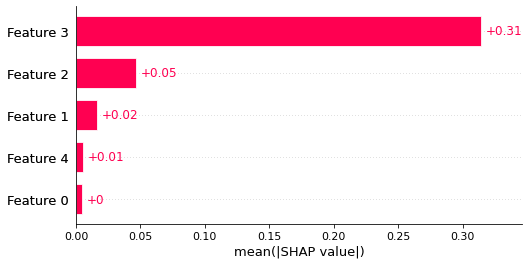

In [14]:
shap.plots.bar(shap.Explanation(shap_values))

In [18]:
shap.Explanation(shap_values)

.values =
array([[ 0.00711776, -0.0074509 , -0.03861272, -0.31878406, -0.00658817],
       [ 0.00607562, -0.01098143, -0.04276424, -0.31890395, -0.0056547 ],
       [ 0.00526058, -0.01434605, -0.04593401, -0.31610611, -0.00484796],
       [ 0.00457561, -0.01776705, -0.04861195, -0.3117134 , -0.00410915],
       [ 0.0039011 , -0.01908401, -0.04749681, -0.31961522,  0.00395162],
       [ 0.00406784, -0.01603358, -0.04607432, -0.32217973,  0.00610105],
       [ 0.00460472, -0.01455895, -0.04733366, -0.30774727, -0.0063759 ],
       [ 0.0037603 , -0.01751149, -0.04960269, -0.30741349, -0.00542925],
       [ 0.00306903, -0.02059549, -0.05147882, -0.30468315, -0.0045963 ],
       [ 0.0024838 , -0.02164053, -0.05040332, -0.31340197,  0.00437318]])

In [9]:
shap.Expashap.plots.bar(shap_values)

AssertionError: You must pass an Explanation object, Cohorts object, or dictionary to bar plot!

shap_values = e.shap_values(X_test)# Force left=0

In [ ]:
import json
from train_cnfqi import run
num_iter=15
results = {'fqi': {}, 'cfqi': {}}
for i in range(num_iter):
    print(str(i))
    printed_bg, printed_fg, performance, nfq_agent = run(verbose=False, is_contrastive=True, evaluations=2, force_left=0)
    results['cfqi'][i] = performance
    printed_bg, printed_fg, performance, nfq_agent = run(verbose=False, is_contrastive=False, evaluations=2, force_left=0)
    results['fqi'][i] = performance
    
#     with open('force_left=0.json', 'w') as f:
#         json.dump(results, f)  

In [ ]:
fqi_results = []
cfqi_results = []
for alg in ['cfqi', 'fqi']:
    for key in results[alg]:
        if alg == 'fqi':
            fqi_results.extend(results[alg][key])
        else:
            cfqi_results.extend(results[alg][key])

In [ ]:
sns.distplot(fqi_results, label='FQI')
sns.distplot(cfqi_results, label='CFQI')
plt.legend()
plt.xlabel("Steps survived")
plt.title("Force left = 0")

# Force Left vs Performance

In [ ]:
import json
from train_cnfqi import run
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

num_iter=10000
results = {}
for i in range(11):
    results[i] = {}
    results[i]['cfqi'] = {}
    results[i]['fqi'] = {}

for i in range(num_iter):
    for f in range(11):
        printed_bg, printed_fg, performance, nfq_agent = run(verbose=False, is_contrastive=True, evaluations=2, force_left=f)
        results[f]['cfqi'][i] = performance
        printed_bg, printed_fg, performance, nfq_agent = run(verbose=False, is_contrastive=False, evaluations=2, force_left=f)
        results[f]['fqi'][i] = performance
    
    with open('force_left_v_performance.json', 'w') as f:
        json.dump(results, f)  



def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

c_success = []
f_success = []
c_errs = []
f_errs = []
for i in range(11):
    cfqi_perf = []
    fqi_perf = []
    for key in results[i]['fqi']:
        fqi_perf.extend(results[i]['fqi'][key])
    for key in results[i]['cfqi']:
        cfqi_perf.extend(results[i]['cfqi'][key])
    
    c_success.append(np.mean(cfqi_perf))
    f_success.append(np.mean(fqi_perf))
    m, h = mean_confidence_interval(cfqi_perf)
    c_errs.append(h)
    m, h = mean_confidence_interval(fqi_perf)
    f_errs.append(h) 
    
x = [k for k in range(11)]
sns.scatterplot(x, c_success, label='CFQI')
plt.errorbar(x, c_success ,yerr=c_errs, linestyle="None")
sns.scatterplot(x, f_success, label='FQI')
plt.errorbar(x, f_success ,yerr=f_errs, linestyle="None")
plt.title("Performance of CFQI and FQI when force on cart is modified")
plt.xlabel("Force Left")
plt.ylabel("Steps Survived")
plt.show()